In [1]:
import sys
import pickle
import numpy as np
import pandas as pd
import torch

sys.path.append('..')
from src.utils import *
from src.models import *
from src.configs import *


from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
rcParams.update(fig_params)

import warnings

%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

## Set device

In [2]:
DEVICE = 'cuda:2' if torch.cuda.is_available() else 'cpu' # set this according to your system
print('Using device:', DEVICE)

Using device: cuda:2


## Load experiments file

In [3]:
FILENAME = 'Experiments_MASSIVE.xlsx'

In [4]:
exp_df = pd.read_excel(os.path.join('..', 'experiments', FILENAME), dtype=FORMAT)
exp_df.head()

,exp_id,seed,torch_dtype,samples_number,features_number,snr_db,informative_frac,folds_number,initialization,epochs_number,learning_rate
0,MASSIVE000,8925,64,1000,100,20,0.5,5,1.0,300,350.0
1,MASSIVE001,65459,64,1000,100,20,0.5,5,1.0,300,350.0
2,MASSIVE002,30300,64,1000,100,20,0.5,5,1.0,300,350.0
3,MASSIVE003,38747,64,1000,100,20,0.5,5,1.0,300,350.0
4,MASSIVE004,26932,64,1000,100,20,0.5,5,1.0,300,350.0


## Run experiments

In [5]:
# Comment lines below to run the massive experiment 
exp_df = exp_df.iloc[[0]].copy()
exp_df

,exp_id,seed,torch_dtype,samples_number,features_number,snr_db,informative_frac,folds_number,initialization,epochs_number,learning_rate
0,MASSIVE000,8925,64,1000,100,20,0.5,5,1.0,300,350.0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1: Train r2: 0.745, Valid r2: 0.712, Test r2: 0.706
Epoch 11: Train r2: 0.763, Valid r2: 0.725, Test r2: 0.732
Epoch 21: Train r2: 0.908, Valid r2: 0.891, Test r2: 0.898
Epoch 31: Train r2: 0.954, Valid r2: 0.946, Test r2: 0.950
Epoch 41: Train r2: 0.991, Valid r2: 0.990, Test r2: 0.989
Epoch 51: Train r2: 0.991, Valid r2: 0.990, Test r2: 0.989
Epoch 61: Train r2: 0.991, Valid r2: 0.990, Test r2: 0.989
Epoch 71: Train r2: 0.991, Valid r2: 0.990, Test r2: 0.989
Epoch 81: Train r2: 0.991, Valid r2: 0.990, Test r2: 0.989
Epoch 91: Train r2: 0.991, Valid r2: 0.990, Test r2: 0.989
Epoch 101: Train r2: 0.991, Valid r2: 0.990, Test r2: 0.989
Epoch 111: Train r2: 0.991, Valid r2: 0.990, Test r2: 0.989
Epoch 121: Train r2: 0.991, Valid r2: 0.990, Test r2: 0.989
Epoch 131: Train r2: 0.991, Valid r2: 0.990, Test r2: 0.989
Epoch 141: Train r2: 0.991, Valid r2: 0.990, Test r2: 0.989
Epoch 151: Train r2: 0.991, Valid r2: 0.990, Test r2: 0.989
Epoch 161: Train r2: 0.991, Valid r2: 0.990, Test r

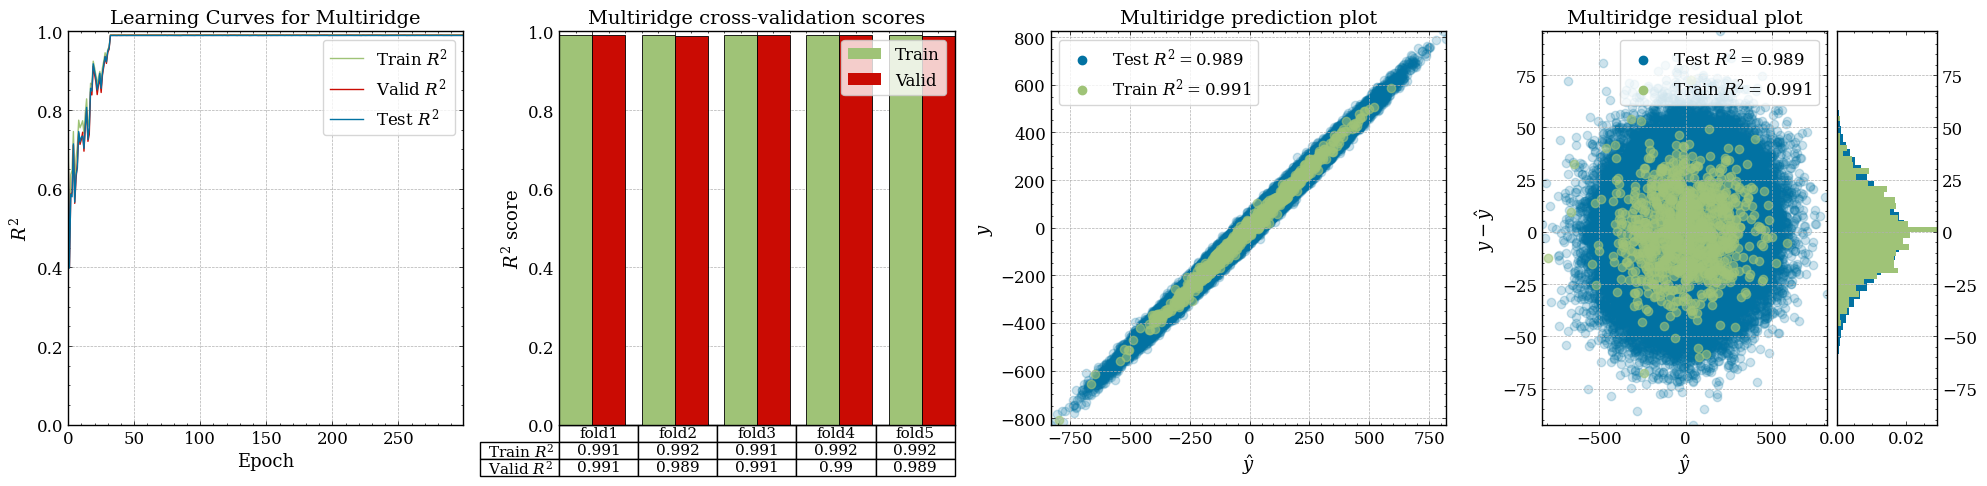

In [8]:
if not sys.warnoptions:
    warnings.simplefilter('ignore')
    os.environ["PYTHONWARNINGS"] = 'ignore'

for i, exp in exp_df.iterrows():
    EXP_ID = exp.exp_id
    SEED = exp.seed
    if exp.torch_dtype == 64:
        DTYPE = torch.float64
    elif exp.torch_dtype == 32:
        DTYPE = torch.float32
    N = exp.samples_number
    D = exp.features_number
    SNR_DB = exp.snr_db
    INFORMATIVE_FRAC = exp.informative_frac
    NUM_FOLDS = exp.folds_number
    INITIALIZATION = exp.initialization
    EPOCHS = exp.epochs_number
    LEARNING_RATE = exp.learning_rate
    
    ### Create output folders
    os.makedirs(os.path.join('..', 'results', 'multiridge', FILENAME.split('.')[0], 'data'), exist_ok=True)
    data_folder = os.path.join('..', 'results', 'multiridge', FILENAME.split('.')[0], 'data')
    os.makedirs(os.path.join('..', 'results', 'multiridge', FILENAME.split('.')[0], 'images'), exist_ok=True)
    images_folder = os.path.join('..', 'results', 'multiridge', FILENAME.split('.')[0], 'images')
    
    ### Data generation
    train, test, features, target, theta_true = generate_synthetic_dataset(n_samples_train=N, n_samples_test=100000, n_features=D, n_informative=int(D*INFORMATIVE_FRAC),
                                                                           snr_db=SNR_DB, random_state=SEED)
    check_snr(train, test, features, target, theta_true, snr_db=SNR_DB)

    ### MultiRidge optimization
    initialization = np.ones(D)*exp.initialization
    learning_rate = LinearLR(initial_lr=LEARNING_RATE, decay=0.999)
    model = MultiRidge(lambda_vector=initialization, folds=NUM_FOLDS, shuffle=True, random_state=SEED, normalize=True,
                       epochs=EPOCHS, learning_rate=learning_rate, scoring={'r2': r2_score},# 'mse': mean_squared_error},
                       verbose=10, device=DEVICE, dtype=DTYPE)
    model.fit(train[features], train[target], eval_set=(test[features], test[target]))
    results_dict = {'exp_id': EXP_ID, 'history_df': model.history_df}#, 'history_coef': history_coef}
    with open(os.path.join(data_folder, f'{EXP_ID}.pickle'), 'wb') as handle:
        pickle.dump(results_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    ### Plot dashboard
    pathfile_mr = os.path.join(images_folder, f'{EXP_ID}')
    fig_params = {'train_color': "#9fc377", 'test_color': "#0272a2", 'valid_color': "#ca0b03"}
    metric_params = {'metric': 'r2', 'metric_func': r2_score, 'metric_label': '$R^2$'}
    plot_monitoring_dashboard_multiridge(train, test, features, target, folds=NUM_FOLDS, model=model, history=model.history_df,
                                         fig_params=fig_params, metric_params=metric_params, savefig=pathfile_mr, show=True)